In [9]:
import numpy as np
import matplotlib.pyplot as plt
import deepxde.deepxde as dde
import deepxde.deepxde.backend as bkd
from datasets import makeTesting
from datasets import parallel_solver, diffusion_reaction_solver
from utils.func import dirichlet
from utils.PDETriple import PDETripleCartesianProd

In [10]:
if False:
    makeTesting()

In [11]:
def pde(x, y, aux):
    D = 0.01
    k = 0.01
    dy_t = dde.grad.jacobian(y, x[1], j=1)
    dy_xx = dde.grad.hessian(y, x[1], j=0)
    out = dy_t - D * dy_xx + k * y**2 - aux
    return out

In [12]:
space = dde.data.GRF(1.0, length_scale = 0.1, N= 1000, interp="cubic")

geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)
vxs = space.eval_batch(space.random(20), np.linspace(0, 1, 101)[:, None])
uxts = parallel_solver(diffusion_reaction_solver, vxs, num_workers = 3)
grid = uxts[0][0].reshape(101 * 101, -1)
uxts = np.asarray([u for grid, u in uxts]).reshape(-1, 101 * 101)


train_vxs = vxs
train_grid = grid
train_uxts = uxts
print(train_vxs.shape, train_grid.shape, train_uxts.shape)

test_data = np.load("datasets/DF_100_0.1_101_101.npz")
test_vxs = test_data["vxs"]
test_grid = test_data["xt"].reshape(-1, 2)
test_uxts = test_data["uxts"].reshape(-1, 101 * 101)
del test_data
print(test_vxs.shape, test_grid.shape, test_uxts.shape)

(20, 101) (10201, 2) (20, 10201)
(100, 101) (10201, 2) (100, 10201)


In [13]:
import torch

data = PDETripleCartesianProd(X_train=(train_vxs, train_grid), y_train=train_uxts, X_test=(test_vxs, test_grid), y_test=test_uxts)

# Net
net = dde.nn.DeepONetCartesianProd(
    [101, 128, 128, 128],
    [2, 128, 128, 128],
    "relu",
    "Glorot normal",
)

net.apply_output_transform(dirichlet)

model = dde.Model(data, net)
model.compile("adam", lr=1E-3, loss= ["mse"], metrics = ["mean l2 relative error"])


Compiling model...
'compile' took 0.000404 s



Training model...

Step      Train loss    Test loss     Test metric   
0         [1.55e-01]    [4.03e-01]    [1.53e+00]    
1000      [1.96e-02]    [3.75e-02]    [4.80e-01]    
2000      [5.65e-02]    [4.67e-02]    [5.37e-01]    
3000      [1.32e-03]    [3.19e-02]    [4.23e-01]    
4000      [1.30e-03]    [2.93e-02]    [4.06e-01]    
5000      [2.09e-03]    [3.73e-02]    [4.41e-01]    
6000      [1.35e-03]    [3.14e-02]    [4.26e-01]    
7000      [9.87e-03]    [3.07e-02]    [4.03e-01]    
8000      [2.15e-03]    [3.13e-02]    [4.04e-01]    
9000      [6.78e-04]    [2.93e-02]    [4.10e-01]    
10000     [3.90e-04]    [3.17e-02]    [4.19e-01]    
11000     [1.40e-03]    [3.21e-02]    [4.09e-01]    
12000     [6.85e-03]    [3.78e-02]    [4.59e-01]    
13000     [5.27e-04]    [3.01e-02]    [4.04e-01]    
14000     [5.11e-03]    [2.97e-02]    [3.97e-01]    
15000     [1.43e-04]    [3.03e-02]    [4.04e-01]    
16000     [2.68e-04]    [2.93e-02]    [4.00e-01]    
17000     [2.14e-04]    [3.

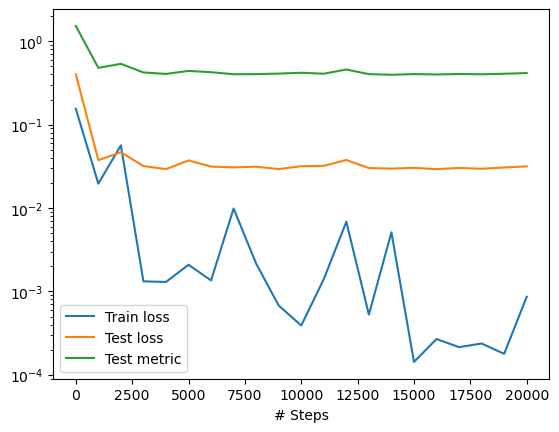

In [14]:
losshistory, train_state = model.train(iterations=20000, batch_size = 1)
dde.utils.plot_loss_history(losshistory)

0.44848472 0.13802013
40
Compiling model...
'compile' took 0.001031 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [7.53e-02]    [3.16e-02]    [4.16e-01]    
1000      [5.65e-04]    [8.95e-03]    [2.34e-01]    
2000      [2.10e-04]    [9.14e-03]    [2.34e-01]    
3000      [4.00e-04]    [8.71e-03]    [2.29e-01]    
4000      [1.55e-04]    [8.71e-03]    [2.27e-01]    
5000      [1.24e-04]    [8.49e-03]    [2.25e-01]    
6000      [1.33e-03]    [9.31e-03]    [2.36e-01]    
7000      [1.22e-04]    [8.56e-03]    [2.25e-01]    
8000      [1.26e-04]    [8.51e-03]    [2.27e-01]    
9000      [2.03e-04]    [8.12e-03]    [2.21e-01]    
10000     [3.24e-05]    [8.12e-03]    [2.21e-01]    
11000     [5.32e-05]    [8.18e-03]    [2.21e-01]    
12000     [7.91e-05]    [8.13e-03]    [2.20e-01]    
13000     [2.72e-04]    [8.35e-03]    [2.25e-01]    
14000     [1.65e-05]    [8.12e-03]    [2.21e-01]    
15000     [5.87e-05]    [8.32e-03]    [2.23e-01]    
16000    

KeyboardInterrupt: 

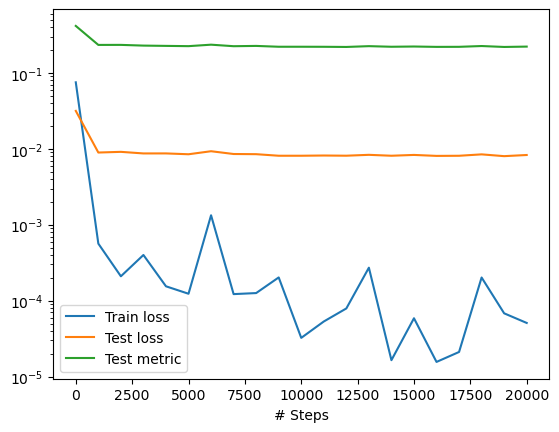

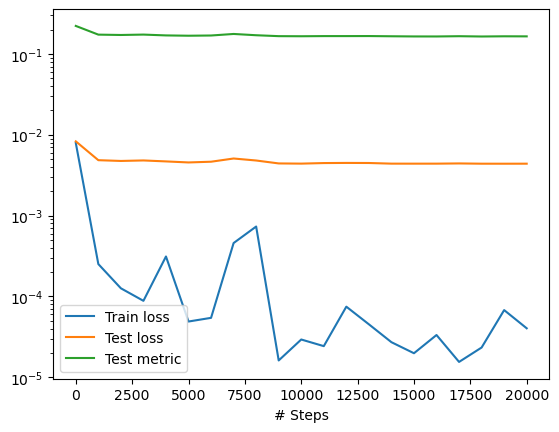

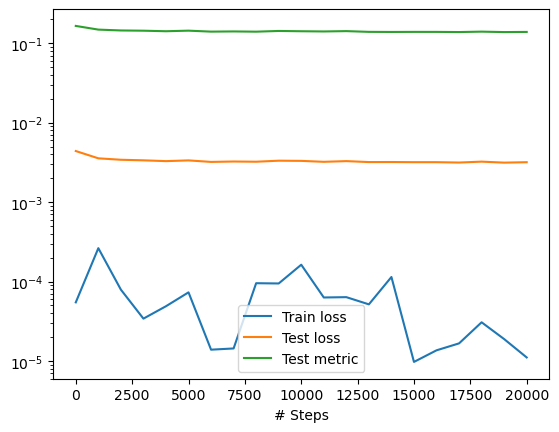

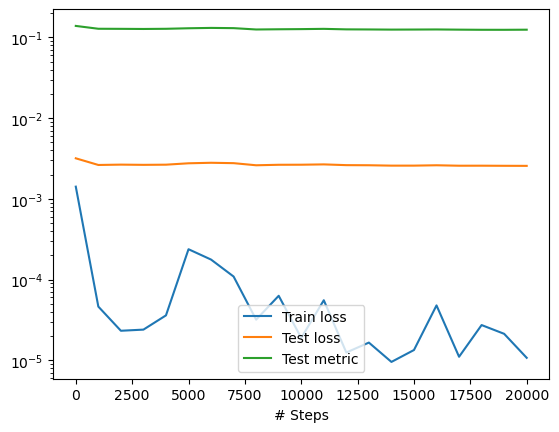

In [21]:

while len(train_vxs) < 1000:
    # generate some vxs to test
    pde_data = dde.data.TimePDE(geomtime, pde, [], num_domain = 20000)
    eval_pts = np.linspace(0, 1, 101)[:, None] # generate 1000 random vxs
    geom = dde.geometry.Interval(0, 1)
    timedomain = dde.geometry.TimeDomain(0, 1)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)
    func_space = dde.data.GRF(1.0, length_scale = 0.1, N= 1000, interp="linear")
    testing_new_data = dde.data.PDEOperatorCartesianProd(pde_data, func_space, eval_pts, 1000, [0])
    testing_model = dde.Model(testing_new_data, net)
    a, _, c = testing_new_data.train_next_batch()
    out = model.predict(a, aux_vars = c, operator = pde)
    
    res = np.mean(np.abs(out), axis = 1)
    print(np.mean(res), np.std(res))
    topk_index = np.argpartition(res, -20)[-20:] # select the top 20 vxs
    topk_vxs = a[0][topk_index]
    uxts = parallel_solver(diffusion_reaction_solver, topk_vxs, num_workers = 6)
    uxts = np.asarray([u for grid, u in uxts]).reshape(-1, 101 * 101)

    # then add the new data to the training set, and train the model
    train_vxs = np.concatenate([train_vxs, topk_vxs], axis = 0)
    train_uxts = np.concatenate([train_uxts, uxts], axis = 0)
    
    print(len(train_vxs))
    data = dde.data.TripleCartesianProd(X_train=(train_vxs, train_grid), y_train=train_uxts, X_test=(test_vxs, test_grid), y_test=test_uxts)
    
    model = dde.Model(data, net)
    batchsize = len(train_vxs) // 10
    lr = 1E-3 * np.exp(-len(train_vxs) / 200)
    model.compile("adam", 
                  lr=1e-3, 
                  metrics = ["mean l2 relative error"], 
                  decay = ("lambda", lambda step: 1 / (1 + 0.5 * (step / (20000 // 5)))))
    losshistory, train_state = model.train(iterations=20000, batch_size = batchsize)
    dde.utils.plot_loss_history(losshistory)


In [20]:
a[0].shape

(1000, 101)